# 🔍 Similarity Search & Clustering
#
## Finding Similar Fire Patterns in the Database
#
This notebook implements the similarity search engine and pattern discovery system
for our fire fingerprinting database. Using both CNN-extracted features and geometric
descriptors, we can find fires with similar burning patterns and discover common archetypes.
#
**Capabilities**: k-NN search, pattern clustering, interactive exploration


## 📋 What You'll Learn
#
1. **Similarity Search Engine**: Building k-Nearest Neighbors search
2. **Feature Fusion**: Combining CNN and geometric features
3. **Pattern Clustering**: Discovering fire archetypes with K-Means
4. **Interactive Queries**: Finding similar fires and exploring patterns
5. **Performance Evaluation**: Search accuracy and clustering quality


## 🛠️ Setup and Imports


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Load processed data function
def load_processed_data(data_dir=None):
    """Load previously processed data"""
    if data_dir is None:
        data_path = config.get_path('processed_data.demo')
    else:
        data_path = Path(data_dir)

    print(f"Loading processed data from {data_path}...")

    # Load fingerprints
    fingerprints = np.load(data_path / 'fingerprints.npy')

    # Load labels and metadata
    with open(data_path / 'labels.pkl', 'rb') as f:
        labels = pickle.load(f)

    with open(data_path / 'metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)

    # Load encoders
    with open(data_path / 'encoders.json', 'r') as f:
        encoders = json.load(f)

    print(f"✓ Loaded {len(fingerprints):,} fingerprints")
    print(f"✓ Fingerprint shape: {fingerprints.shape}")

    return fingerprints, labels, metadata, encoders

print("🔥 Fire Fingerprinting System - Similarity Search & Clustering")
print("=" * 60)
print("🔍 Building similarity search engine and pattern discovery")
print("💡 This notebook demonstrates k-NN search and clustering")

🔥 Fire Fingerprinting System - Similarity Search & Clustering
🔍 Building similarity search engine and pattern discovery
💡 This notebook demonstrates k-NN search and clustering


In [ ]:
# 📂 Load Configuration
from pathlib import Path
import sys

src_path = Path.cwd().parent / 'src' if 'notebooks' in str(Path.cwd()) else Path.cwd() / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from config_loader import FirePrintConfig
config = FirePrintConfig()

print("="*60)
print("📂 Configuration Loaded")
print("="*60)
print(f"Data: {config.get_path('processed_data.demo')}")
print(f"Search: {config.get_path('search.demo')}")
print(f"Outputs: {config.get_path('outputs_root')}")
print("="*60)


## 🏗️ Fire Similarity Search Engine
#
A comprehensive similarity search system that combines multiple feature types
and provides efficient nearest neighbor queries.


In [ ]:
class FireSimilaritySearch:
    """Similarity search engine for fire patterns"""

    def __init__(self, feature_database_path=None):
        if feature_database_path is None:
            self.database_path = config.get_path('processed_data.feature_database')
        else:
            self.database_path = Path(feature_database_path)
        self.features_df = None
        self.normalized_features = None
        self.cnn_features = None
        self.metadata = None
        self.labels = None
        self.fingerprints = None

        # Search engines for different feature types
        self.search_engines = {}
        self.scalers = {}

        # Clustering results
        self.clusters = None
        self.cluster_centers = None

    def load_database(self):
        """Load the feature database"""
        print(f"Loading feature database from {self.database_path}...")

        try:
            # Load features
            self.features_df = pd.read_csv(self.database_path / 'raw_features.csv')
            self.normalized_features = pd.read_csv(self.database_path / 'normalized_features.csv')

            # Load metadata
            self.metadata = pd.read_csv(self.database_path / 'fire_metadata.csv')

            # Load CNN features if available
            cnn_features_path = Path('demo_cnn_features.npy')
            if cnn_features_path.exists():
                self.cnn_features = np.load(cnn_features_path)
                print(f"✓ Loaded CNN features: {self.cnn_features.shape}")

            # Load fingerprints if available
            fingerprints_path = Path('demo_processed_data/fingerprints.npy')
            if fingerprints_path.exists():
                self.fingerprints = np.load(fingerprints_path)
                print(f"✓ Loaded fingerprints: {self.fingerprints.shape}")

            # Extract labels
            label_columns = ['fire_type', 'ignition_cause', 'state', 'size_category']
            self.labels = self.metadata[label_columns].to_dict('records')

            print("✓ Feature database loaded successfully")
            print(f"  Features: {len(self.features_df)} fires × {len(self.features_df.columns)} features")
            print(f"  Metadata: {len(self.metadata)} records")

        except Exception as e:
            print(f"Error loading database: {e}")
            return False

        return True

    def build_search_engine(self, feature_type='geometric', n_neighbors=10, algorithm='auto'):
        """Build k-NN search engine for specified feature type"""
        print(f"Building {feature_type} search engine...")

        if feature_type == 'geometric':
            # Use normalized geometric features
            features = self.normalized_features.select_dtypes(include=[np.number]).fillna(0).values

        elif feature_type == 'cnn' and self.cnn_features is not None:
            # Use CNN-extracted features
            features = self.cnn_features

        elif feature_type == 'combined' and self.cnn_features is not None:
            # Combine geometric and CNN features
            geometric_features = self.normalized_features.select_dtypes(include=[np.number]).fillna(0).values
            # Normalize CNN features
            cnn_scaler = StandardScaler()
            cnn_normalized = cnn_scaler.fit_transform(self.cnn_features)
            # Concatenate features
            features = np.concatenate([geometric_features, cnn_normalized], axis=1)
            self.scalers['cnn'] = cnn_scaler

        else:
            print(f"Feature type '{feature_type}' not available")
            return False

        # Normalize features
        scaler = StandardScaler()
        features_normalized = scaler.fit_transform(features)
        self.scalers[feature_type] = scaler

        # Build k-NN search engine
        nn_search = NearestNeighbors(
            n_neighbors=min(n_neighbors + 1, len(features)),  # +1 because query will be included
            algorithm=algorithm,
            metric='cosine'  # Cosine similarity for high-dimensional features
        )

        nn_search.fit(features_normalized)
        self.search_engines[feature_type] = nn_search

        print(f"✓ Built {feature_type} search engine with {len(features)} samples")
        return True

    def find_similar_fires(self, query_index, feature_type='geometric', n_neighbors=5, return_distances=False):
        """Find fires similar to the query fire"""
        if feature_type not in self.search_engines:
            print(f"Search engine for '{feature_type}' not built. Call build_search_engine() first.")
            return None

        # Get query features
        if feature_type == 'geometric':
            query_features = self.normalized_features.iloc[query_index:query_index+1].select_dtypes(include=[np.number]).fillna(0).values
        elif feature_type == 'cnn' and self.cnn_features is not None:
            query_features = self.cnn_features[query_index:query_index+1]
        elif feature_type == 'combined' and self.cnn_features is not None:
            geometric_features = self.normalized_features.iloc[query_index:query_index+1].select_dtypes(include=[np.number]).fillna(0).values
            cnn_features = self.cnn_features[query_index:query_index+1]
            query_features = np.concatenate([geometric_features, cnn_features], axis=1)

        # Normalize query
        query_normalized = self.scalers[feature_type].transform(query_features)

        # Find neighbors
        distances, indices = self.search_engines[feature_type].kneighbors(
            query_normalized, n_neighbors=n_neighbors+1, return_distance=True
        )

        # Remove self-match (first result is always the query itself)
        distances = distances[0][1:]
        indices = indices[0][1:]

        # Get metadata for similar fires
        similar_fires = []
        for i, idx in enumerate(indices):
            fire_data = {
                'index': int(idx),
                'distance': float(distances[i]),
                'metadata': self.metadata.iloc[idx].to_dict(),
                'labels': {k: v for k, v in self.labels[idx].items()},
                'features': self.features_df.iloc[idx].to_dict()
            }
            similar_fires.append(fire_data)

        if return_distances:
            return similar_fires, distances
        else:
            return similar_fires

    def batch_similarity_search(self, query_indices, feature_type='geometric', n_neighbors=5):
        """Perform similarity search for multiple query fires"""
        results = []

        for query_idx in tqdm(query_indices, desc="Batch similarity search"):
            similar_fires = self.find_similar_fires(query_idx, feature_type, n_neighbors)
            if similar_fires:
                results.append({
                    'query_index': query_idx,
                    'query_metadata': self.metadata.iloc[query_idx].to_dict(),
                    'similar_fires': similar_fires
                })

        return results

    def discover_fire_patterns(self, n_clusters=8, feature_type='geometric', random_state=42):
        """Discover common fire patterns using clustering"""
        print(f"Discovering fire patterns with {n_clusters} clusters using {feature_type} features...")

        # Get features for clustering
        if feature_type == 'geometric':
            features = self.normalized_features.select_dtypes(include=[np.number]).fillna(0).values
        elif feature_type == 'cnn' and self.cnn_features is not None:
            features = StandardScaler().fit_transform(self.cnn_features)
        elif feature_type == 'combined' and self.cnn_features is not None:
            geometric_features = self.normalized_features.select_dtypes(include=[np.number]).fillna(0).values
            cnn_features = StandardScaler().fit_transform(self.cnn_features)
            features = np.concatenate([geometric_features, cnn_features], axis=1)
        else:
            print(f"Feature type '{feature_type}' not available")
            return None

        # Perform K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        clusters = kmeans.fit_predict(features)

        # Store results
        self.clusters = clusters
        self.cluster_centers = kmeans.cluster_centers_

        # Analyze cluster characteristics
        cluster_analysis = self._analyze_clusters(clusters, features)

        print("✓ Pattern discovery complete")
        print(f"  Clusters: {n_clusters}")
        print(f"  Silhouette Score: {cluster_analysis['silhouette_score']:.3f}")

        return {
            'clusters': clusters,
            'cluster_centers': self.cluster_centers,
            'analysis': cluster_analysis
        }

    def _analyze_clusters(self, clusters, features):
        """Analyze cluster characteristics and quality"""
        n_clusters = len(np.unique(clusters))

        # Calculate clustering quality metrics
        try:
            silhouette = silhouette_score(features, clusters)
        except:
            silhouette = 0.0

        try:
            calinski = calinski_harabasz_score(features, clusters)
        except:
            calinski = 0.0

        # Analyze cluster sizes and characteristics
        cluster_sizes = []
        cluster_features = []

        for i in range(n_clusters):
            cluster_mask = clusters == i
            cluster_size = np.sum(cluster_mask)
            cluster_sizes.append(cluster_size)

            # Average feature values for cluster
            cluster_avg_features = np.mean(features[cluster_mask], axis=0)
            cluster_features.append(cluster_avg_features)

        # Find representative fires for each cluster
        representatives = []
        for i in range(n_clusters):
            cluster_mask = clusters == i
            cluster_indices = np.where(cluster_mask)[0]

            # Find fire closest to cluster center
            center = self.cluster_centers[i]
            distances = np.sum((features[cluster_mask] - center) ** 2, axis=1)
            closest_idx = cluster_indices[np.argmin(distances)]
            representatives.append(int(closest_idx))

        return {
            'silhouette_score': silhouette,
            'calinski_harabasz_score': calinski,
            'cluster_sizes': cluster_sizes,
            'cluster_features': cluster_features,
            'representatives': representatives
        }

    def get_cluster_info(self, cluster_id):
        """Get detailed information about a specific cluster"""
        if self.clusters is None:
            print("No clustering results available. Run discover_fire_patterns() first.")
            return None

        cluster_mask = self.clusters == cluster_id
        cluster_indices = np.where(cluster_mask)[0]

        # Get cluster statistics
        cluster_fires = self.metadata.iloc[cluster_indices]
        cluster_labels = [self.labels[i] for i in cluster_indices]

        # Analyze fire characteristics in cluster
        fire_types = cluster_fires['original_fire_type'].value_counts()
        states = cluster_fires['state'].value_counts()
        causes = cluster_fires['ignition_cause'].value_counts()

        # Size distribution
        sizes = cluster_fires['area_ha'].describe()

        return {
            'cluster_id': cluster_id,
            'size': len(cluster_indices),
            'fire_types': fire_types.to_dict(),
            'states': states.to_dict(),
            'causes': causes.to_dict(),
            'size_stats': sizes.to_dict(),
            'representative_fires': cluster_indices[:5].tolist()  # First 5 fires
        }

print("✓ Complete Fire Similarity Search engine created")


✓ Complete Fire Similarity Search engine created


## 🧪 Similarity Search Demonstration
#
Let's test the similarity search system with our processed data.


In [ ]:
# Initialize similarity search engine
search_engine = FireSimilaritySearch()

# Load the feature database
if not search_engine.load_database():
    print("Failed to load database. Creating demo data...")

    # Create demo data if database doesn't exist
    fingerprints, labels, metadata, encoders = load_processed_data()  # Uses config
    features_df = pd.read_csv(config.get_path('outputs.demo_features_csv'))
    normalized_features = pd.read_csv(config.get_path('outputs.demo_features_normalized'))

    # Manually set up search engine
    search_engine.features_df = features_df
    search_engine.normalized_features = normalized_features
    search_engine.metadata = pd.DataFrame(metadata)
    search_engine.labels = labels

# Build search engines for different feature types
search_engine.build_search_engine('geometric', n_neighbors=10)
if search_engine.cnn_features is not None:
    search_engine.build_search_engine('cnn', n_neighbors=10)
    search_engine.build_search_engine('combined', n_neighbors=10)

print("✓ Search engines built and ready")


Loading feature database from fire_feature_database...
✓ Loaded CNN features: (50, 256)
✓ Loaded fingerprints: (50, 224, 224, 4)
✓ Feature database loaded successfully
  Features: 50 fires × 23 features
  Metadata: 50 records
Building geometric search engine...
✓ Built geometric search engine with 50 samples
Building cnn search engine...
✓ Built cnn search engine with 50 samples
Building combined search engine...
✓ Built combined search engine with 50 samples
✓ Search engines built and ready


## 🔍 Single Fire Similarity Search
#
Find fires similar to a specific query fire.


In [6]:
# Select a query fire
query_index = 0
query_metadata = search_engine.metadata.iloc[query_index]

print("🔍 Single Fire Similarity Search")
print("=" * 40)
print(f"Query Fire: {query_metadata['fire_id']}")
print(f"Type: {query_metadata['original_fire_type']}")
print(f"State: {query_metadata['state']}")
print(f"Area: {query_metadata['area_ha']:.1f} ha")

# Search for similar fires using geometric features
similar_fires = search_engine.find_similar_fires(query_index, 'geometric', n_neighbors=5)

if similar_fires:
    print(f"\n📊 Top 5 Similar Fires (Geometric Features):")
    print("-" * 50)
    for i, fire in enumerate(similar_fires, 1):
        meta = fire['metadata']
        print(f"{i}. Fire {meta['fire_id']} - {meta['original_fire_type']} "
              f"({meta['area_ha']:.1f} ha) - Distance: {fire['distance']:.3f}")

# If CNN features available, compare with CNN-based search
if 'cnn' in search_engine.search_engines:
    similar_fires_cnn = search_engine.find_similar_fires(query_index, 'cnn', n_neighbors=5)
    print(f"\n🔥 Top 5 Similar Fires (CNN Features):")
    print("-" * 50)
    for i, fire in enumerate(similar_fires_cnn, 1):
        meta = fire['metadata']
        print(f"{i}. Fire {meta['fire_id']} - {meta['original_fire_type']} "
              f"({meta['area_ha']:.1f} ha) - Distance: {fire['distance']:.3f}")


🔍 Single Fire Similarity Search
Query Fire: nan
Type: Prescribed Burn
State: 5
Area: 4.0 ha

📊 Top 5 Similar Fires (Geometric Features):
--------------------------------------------------
1. Fire 999 - Prescribed Burn (203.0 ha) - Distance: 0.059
2. Fire nan - Bushfire (75.0 ha) - Distance: 0.161
3. Fire 092 - Bushfire (16.0 ha) - Distance: 0.181
4. Fire 999 - Prescribed Burn (31.0 ha) - Distance: 0.185
5. Fire 999 - Unknown (2.0 ha) - Distance: 0.217

🔥 Top 5 Similar Fires (CNN Features):
--------------------------------------------------
1. Fire nan - Bushfire (75.0 ha) - Distance: 0.030
2. Fire 19655.0 - Bushfire (2.0 ha) - Distance: 0.048
3. Fire 999 - Unknown (2.0 ha) - Distance: 0.061
4. Fire 999 - Prescribed Burn (31.0 ha) - Distance: 0.062
5. Fire 092 - Bushfire (16.0 ha) - Distance: 0.075


## 📊 Batch Similarity Search
#
Search for similar fires across multiple queries to understand search consistency.


In [7]:
# Perform batch search on first 10 fires
batch_queries = list(range(min(10, len(search_engine.metadata))))
batch_results = search_engine.batch_similarity_search(batch_queries, 'geometric', n_neighbors=3)

print("📊 Batch Similarity Search Results")
print("=" * 40)
print(f"Processed {len(batch_results)} query fires")

# Analyze search consistency
search_consistency = []

for result in batch_results:
    query_meta = result['query_metadata']
    similar_types = [fire['metadata']['original_fire_type'] for fire in result['similar_fires']]

    # Check if similar fires have same type as query
    type_matches = sum(1 for t in similar_types if t == query_meta['original_fire_type'])
    consistency_score = type_matches / len(similar_types)
    search_consistency.append(consistency_score)

    print(f"Query: {query_meta['fire_id']} ({query_meta['original_fire_type']}) "
          f"→ {type_matches}/{len(similar_types)} type matches "
          f"(Consistency: {consistency_score:.2f})")

print(f"\nAverage search consistency: {np.mean(search_consistency):.3f}")


Batch similarity search: 100%|██████████| 10/10 [00:00<00:00, 504.35it/s]

📊 Batch Similarity Search Results
Processed 10 query fires
Query: nan (Prescribed Burn) → 1/3 type matches (Consistency: 0.33)
Query: 999 (Prescribed Burn) → 3/3 type matches (Consistency: 1.00)
Query: 999 (Unknown) → 0/3 type matches (Consistency: 0.00)
Query: 999 (Prescribed Burn) → 1/3 type matches (Consistency: 0.33)
Query: 639813 (Prescribed Burn) → 1/3 type matches (Consistency: 0.33)
Query: 999 (Unknown) → 1/3 type matches (Consistency: 0.33)
Query: 999 (Unknown) → 1/3 type matches (Consistency: 0.33)
Query: 9456.0 (Bushfire) → 0/3 type matches (Consistency: 0.00)
Query: nan (Bushfire) → 1/3 type matches (Consistency: 0.33)
Query: 999 (Prescribed Burn) → 3/3 type matches (Consistency: 1.00)

Average search consistency: 0.400


## 🎯 Pattern Discovery with Clustering
#
Discover common fire patterns by clustering the feature space.


In [8]:
# Discover fire patterns
n_clusters = 5  # Adjust based on dataset size
clustering_results = search_engine.discover_fire_patterns(
    n_clusters=n_clusters,
    feature_type='geometric'
)

if clustering_results:
    clusters = clustering_results['clusters']
    analysis = clustering_results['analysis']

    print("🎯 Fire Pattern Discovery Results")
    print("=" * 40)
    print(f"Number of clusters: {n_clusters}")
    print(f"Silhouette Score: {analysis['silhouette_score']:.3f}")
    print(f"Calinski-Harabasz Score: {analysis['calinski_harabasz_score']:.1f}")

    print(f"\nCluster Sizes:")
    for i, size in enumerate(analysis['cluster_sizes']):
        percentage = size / len(clusters) * 100
        print(f"  Cluster {i}: {size} fires ({percentage:.1f}%)")


Discovering fire patterns with 5 clusters using geometric features...
✓ Pattern discovery complete
  Clusters: 5
  Silhouette Score: 0.607
🎯 Fire Pattern Discovery Results
Number of clusters: 5
Silhouette Score: 0.607
Calinski-Harabasz Score: 3072.5

Cluster Sizes:
  Cluster 0: 43 fires (86.0%)
  Cluster 1: 1 fires (2.0%)
  Cluster 2: 1 fires (2.0%)
  Cluster 3: 1 fires (2.0%)
  Cluster 4: 4 fires (8.0%)
✓ Pattern discovery complete
  Clusters: 5
  Silhouette Score: 0.607
🎯 Fire Pattern Discovery Results
Number of clusters: 5
Silhouette Score: 0.607
Calinski-Harabasz Score: 3072.5

Cluster Sizes:
  Cluster 0: 43 fires (86.0%)
  Cluster 1: 1 fires (2.0%)
  Cluster 2: 1 fires (2.0%)
  Cluster 3: 1 fires (2.0%)
  Cluster 4: 4 fires (8.0%)


## 📈 Cluster Analysis and Visualization
#
Analyze the characteristics of each discovered fire pattern cluster.


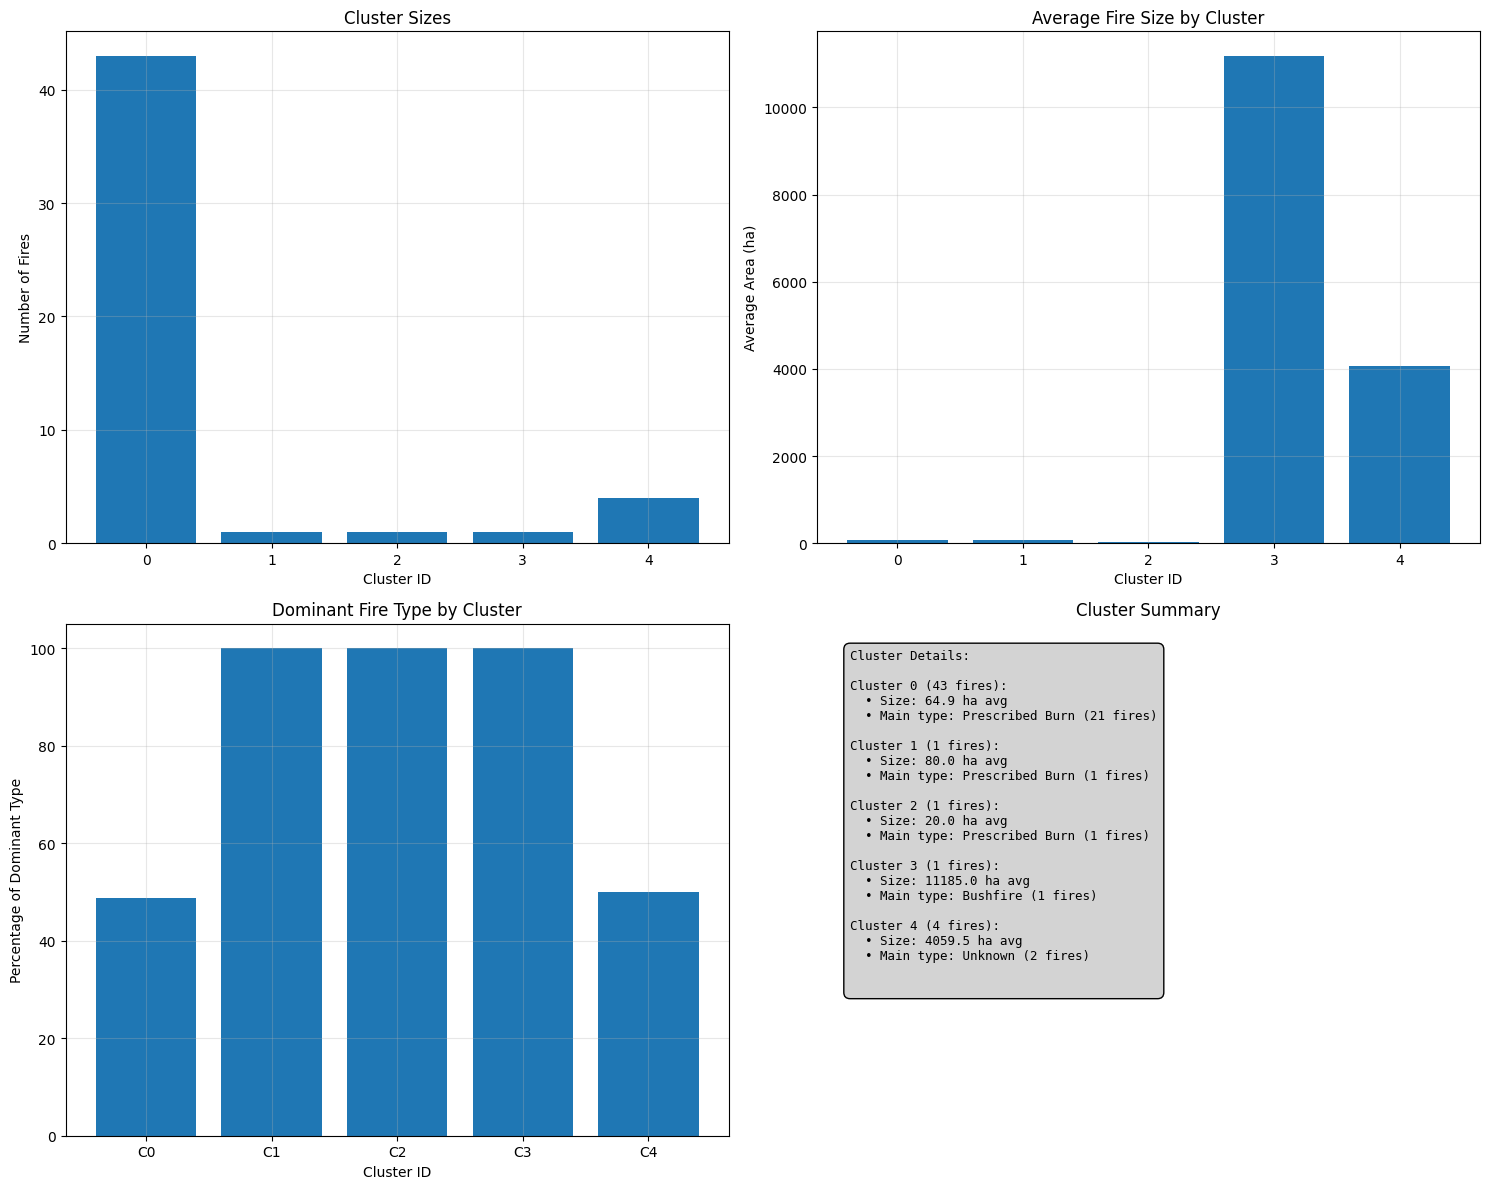


📋 Detailed Cluster Analysis

🔥 Cluster 0 (43 fires)
   Size: 64.9 ± 117.8 ha
   Dominant fire type: Prescribed Burn
   Dominant state: 6
   Sample fires: [0, 1, 2, 3, 4]

🔥 Cluster 1 (1 fires)
   Size: 80.0 ± nan ha
   Dominant fire type: Prescribed Burn
   Dominant state: 6
   Sample fires: [41]

🔥 Cluster 2 (1 fires)
   Size: 20.0 ± nan ha
   Dominant fire type: Prescribed Burn
   Dominant state: 2
   Sample fires: [43]

🔥 Cluster 3 (1 fires)
   Size: 11185.0 ± nan ha
   Dominant fire type: Bushfire
   Dominant state: 6
   Sample fires: [47]

🔥 Cluster 4 (4 fires)
   Size: 4059.5 ± 8014.3 ha
   Dominant fire type: Unknown
   Dominant state: 6
   Sample fires: [9, 12, 13, 27]


In [9]:
def analyze_clusters(search_engine, clustering_results):
    """Analyze and visualize cluster characteristics"""
    if not clustering_results:
        return

    clusters = clustering_results['clusters']
    analysis = clustering_results['analysis']

    # Analyze each cluster
    cluster_summaries = []
    for cluster_id in range(len(analysis['cluster_sizes'])):
        cluster_info = search_engine.get_cluster_info(cluster_id)
        if cluster_info:
            cluster_summaries.append(cluster_info)

    # Create cluster summary visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Cluster sizes
    cluster_ids = [c['cluster_id'] for c in cluster_summaries]
    cluster_sizes = [c['size'] for c in cluster_summaries]
    axes[0, 0].bar(cluster_ids, cluster_sizes)
    axes[0, 0].set_title('Cluster Sizes')
    axes[0, 0].set_xlabel('Cluster ID')
    axes[0, 0].set_ylabel('Number of Fires')
    axes[0, 0].grid(True, alpha=0.3)

    # Average fire sizes by cluster
    avg_sizes = [c['size_stats']['mean'] for c in cluster_summaries]
    axes[0, 1].bar(cluster_ids, avg_sizes)
    axes[0, 1].set_title('Average Fire Size by Cluster')
    axes[0, 1].set_xlabel('Cluster ID')
    axes[0, 1].set_ylabel('Average Area (ha)')
    axes[0, 1].grid(True, alpha=0.3)

    # Most common fire types by cluster
    fire_type_data = []
    for c in cluster_summaries:
        most_common = max(c['fire_types'].items(), key=lambda x: x[1])
        fire_type_data.append((most_common[0], most_common[1] / c['size'] * 100))

    types, percentages = zip(*fire_type_data)
    axes[1, 0].bar(range(len(types)), percentages)
    axes[1, 0].set_title('Dominant Fire Type by Cluster')
    axes[1, 0].set_xlabel('Cluster ID')
    axes[1, 0].set_ylabel('Percentage of Dominant Type')
    axes[1, 0].set_xticks(range(len(types)))
    axes[1, 0].set_xticklabels([f'C{i}' for i in range(len(types))])
    axes[1, 0].grid(True, alpha=0.3)

    # Cluster details text
    details_text = "Cluster Details:\n\n"
    for c in cluster_summaries:
        details_text += f"Cluster {c['cluster_id']} ({c['size']} fires):\n"
        details_text += f"  • Size: {c['size_stats']['mean']:.1f} ha avg\n"
        dominant_type = max(c['fire_types'].items(), key=lambda x: x[1])
        details_text += f"  • Main type: {dominant_type[0]} ({dominant_type[1]} fires)\n\n"

    axes[1, 1].text(0.05, 0.95, details_text, transform=axes[1, 1].transAxes,
                    fontsize=9, verticalalignment='top', fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))
    axes[1, 1].set_title('Cluster Summary')
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.savefig('cluster_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed cluster information
    print("\n📋 Detailed Cluster Analysis")
    print("=" * 50)
    for c in cluster_summaries:
        print(f"\n🔥 Cluster {c['cluster_id']} ({c['size']} fires)")
        print(f"   Size: {c['size_stats']['mean']:.1f} ± {c['size_stats']['std']:.1f} ha")
        print(f"   Dominant fire type: {max(c['fire_types'].items(), key=lambda x: x[1])[0]}")
        print(f"   Dominant state: {max(c['states'].items(), key=lambda x: x[1])[0]}")
        print(f"   Sample fires: {c['representative_fires']}")

# Analyze clusters
analyze_clusters(search_engine, clustering_results)


## 🎨 Interactive Pattern Exploration
#
Explore individual clusters and their representative fires.


🎨 Exploring Cluster 0
Cluster size: 43 fires
Average size: 64.9 ha
Dominant type: Prescribed Burn

Representative fires from cluster 0:
1. Fire nan: Prescribed Burn, 4.0 ha, Fractal dim: 1.000
2. Fire 999: Prescribed Burn, 509.0 ha, Fractal dim: 1.009


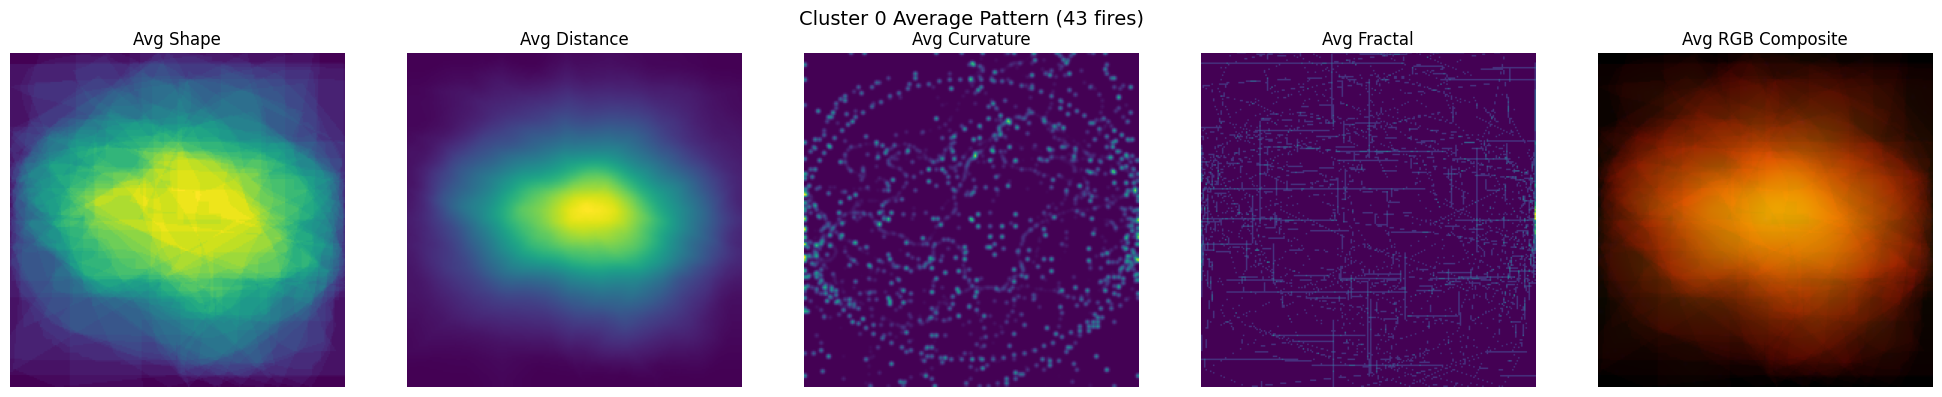

🎨 Exploring Cluster 1
Cluster size: 1 fires
Average size: 80.0 ha
Dominant type: Prescribed Burn

Representative fires from cluster 1:
1. Fire 999: Prescribed Burn, 80.0 ha, Fractal dim: 0.000


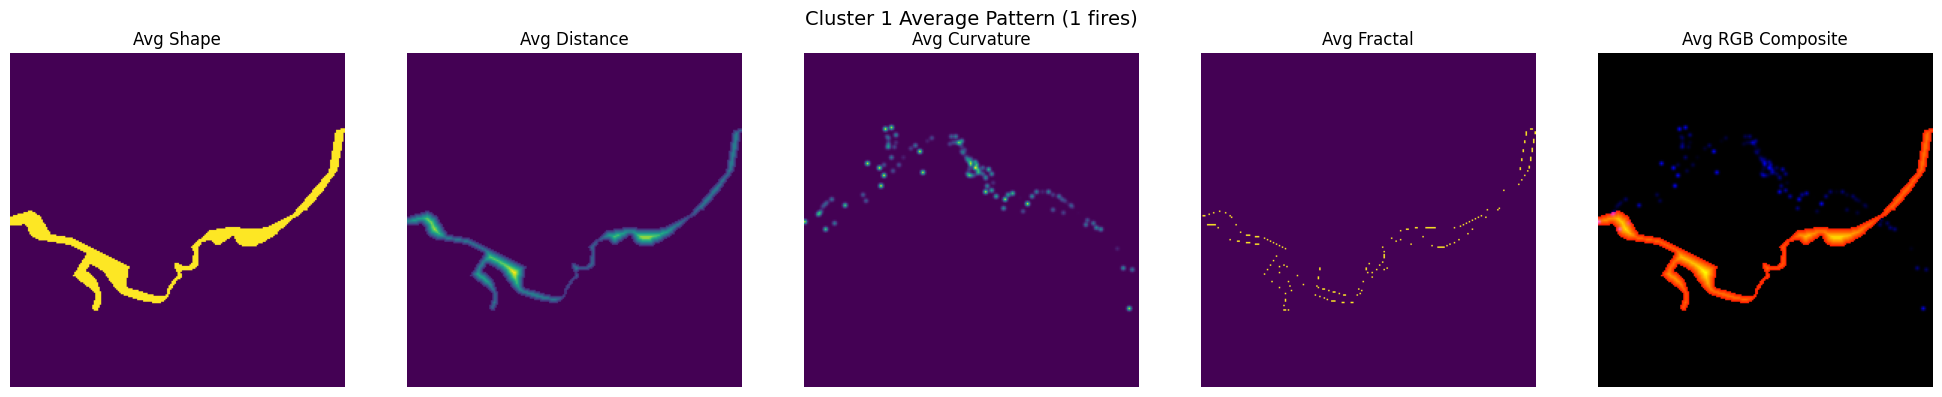

🎨 Exploring Cluster 2
Cluster size: 1 fires
Average size: 20.0 ha
Dominant type: Prescribed Burn

Representative fires from cluster 2:
1. Fire nan: Prescribed Burn, 20.0 ha, Fractal dim: 1.140


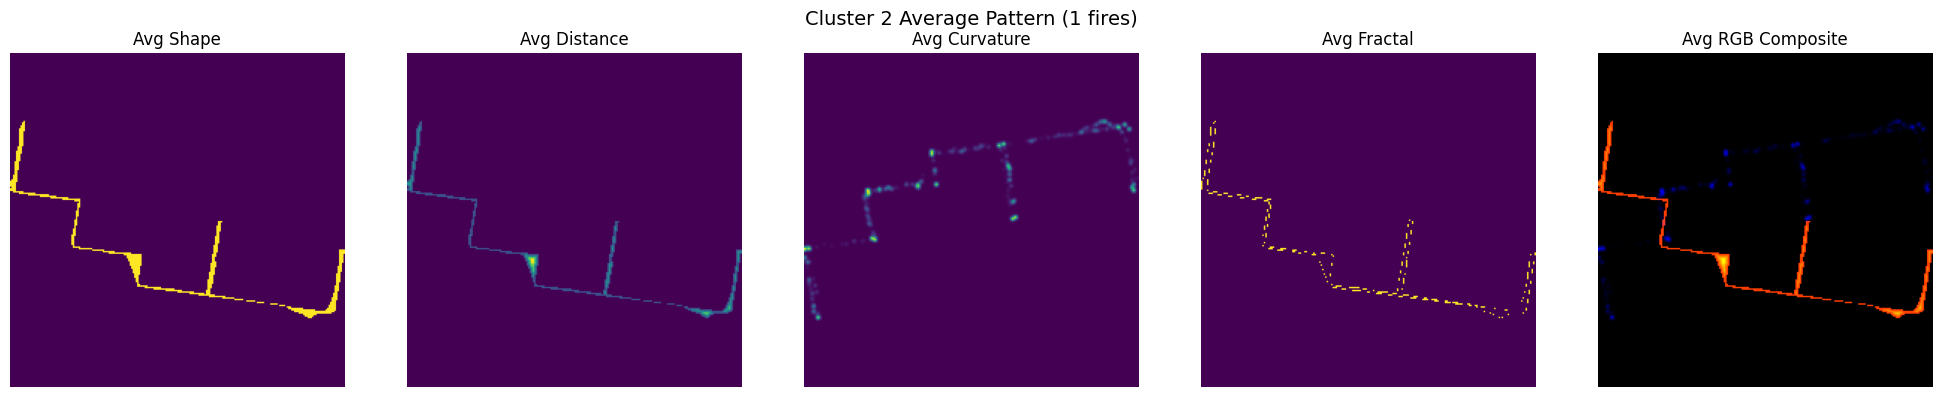

In [11]:
def explore_cluster_patterns(search_engine, cluster_id, n_examples=3):
    """Explore patterns within a specific cluster"""
    if search_engine.clusters is None:
        print("No clustering results available.")
        return

    cluster_info = search_engine.get_cluster_info(cluster_id)
    if not cluster_info:
        return

    print(f"🎨 Exploring Cluster {cluster_id}")
    print("=" * 40)
    print(f"Cluster size: {cluster_info['size']} fires")
    print(f"Average size: {cluster_info['size_stats']['mean']:.1f} ha")
    print(f"Dominant type: {max(cluster_info['fire_types'].items(), key=lambda x: x[1])[0]}")

    # Show representative fires
    rep_indices = cluster_info['representative_fires'][:n_examples]

    print(f"\nRepresentative fires from cluster {cluster_id}:")
    for i, idx in enumerate(rep_indices):
        meta = search_engine.metadata.iloc[idx]
        features = search_engine.features_df.iloc[idx]
        print(f"{i+1}. Fire {meta['fire_id']}: {meta['original_fire_type']}, "
              f"{meta['area_ha']:.1f} ha, Fractal dim: {features.get('fractal_dimension', 'N/A'):.3f}")

    # Visualize cluster feature distributions if fingerprints available
    if search_engine.fingerprints is not None:
        cluster_mask = search_engine.clusters == cluster_id
        cluster_fingerprints = search_engine.fingerprints[cluster_mask]

        if len(cluster_fingerprints) > 0:
            # Create visualization of cluster patterns
            fig, axes = plt.subplots(1, 5, figsize=(20, 4))

            # Average fingerprint for cluster
            avg_fingerprint = np.mean(cluster_fingerprints, axis=0)

            channel_names = ['Shape', 'Distance', 'Curvature', 'Fractal', 'RGB Composite']
            for i in range(4):
                axes[i].imshow(avg_fingerprint[:, :, i], cmap='viridis')
                axes[i].set_title(f'Avg {channel_names[i]}')
                axes[i].axis('off')

            # RGB composite
            rgb_composite = avg_fingerprint[:, :, :3]
            axes[4].imshow(rgb_composite)
            axes[4].set_title('Avg RGB Composite')
            axes[4].axis('off')

            plt.suptitle(f'Cluster {cluster_id} Average Pattern ({len(cluster_fingerprints)} fires)',
                        fontsize=14)
            plt.tight_layout()
            plt.savefig(f'cluster_{cluster_id}_pattern.png', dpi=300, bbox_inches='tight')
            plt.show()

# Explore first few clusters
if search_engine.clusters is not None:
    n_clusters = len(np.unique(search_engine.clusters))
    for cluster_id in range(min(3, n_clusters)):
        explore_cluster_patterns(search_engine, cluster_id, n_examples=2)


## 🔍 Cross-Feature Search Comparison
#
Compare similarity search results using different feature types.


In [14]:
def compare_search_methods(search_engine, query_index, n_neighbors=5):
    """Compare similarity search results across different feature types"""
    query_meta = search_engine.metadata.iloc[query_index]

    print("🔍 Cross-Feature Search Comparison")
    print("=" * 50)
    print(f"Query: Fire {query_meta['fire_id']} - {query_meta['original_fire_type']} "
          f"({query_meta['area_ha']:.1f} ha)")

    results = {}

    # Search with each available method
    for method in ['geometric', 'cnn', 'combined']:
        if method in search_engine.search_engines:
            similar = search_engine.find_similar_fires(query_index, method, n_neighbors)
            if similar:
                results[method] = similar

    # Compare results
    if results:
        print(f"\n📊 Comparison of top {n_neighbors} similar fires:")
        print("-" * 80)
        print(f"{'Rank':<8}{'Geometric':<25}{'CNN':<25}{'Combined':<25}")
        print("-" * 80)

        for i in range(n_neighbors):
            result_str = f"{i+1}.<8"

            for method in ['geometric', 'cnn', 'combined']:
                if method in results:
                    if i < len(results[method]):
                        fire = results[method][i]
                        meta = fire['metadata']
                        fire_str = f"{meta['fire_id']!s:<8} ({fire['distance']:.3f})"
                        result_str += f"{fire_str:<25}"
                    else:
                        result_str += f"{'N/A':<25}"
                else:
                    result_str += f"{'N/A':<25}"

            print(result_str)

        # Calculate agreement between methods
        if len(results) > 1:
            print(f"\n🤝 Method Agreement Analysis:")
            agreements = []

            for i in range(n_neighbors):
                fire_sets = []
                for method in ['geometric', 'cnn', 'combined']:
                    if method in results:
                        if i < len(results[method]):
                            fire_sets.append(results[method][i]['index'])

                if len(fire_sets) > 1:
                    # Check pairwise agreement
                    pairs_agree = sum(1 for j in range(1, len(fire_sets)) if fire_sets[0] == fire_sets[j])
                    agreement_rate = pairs_agree / (len(fire_sets) - 1)
                    agreements.append(agreement_rate)

            if agreements:
                print(f"  Average agreement across methods: {np.mean(agreements):.3f}")

# Compare search methods for a few queries
for query_idx in [0, 1, 2]:
    if query_idx < len(search_engine.metadata):
        compare_search_methods(search_engine, query_idx, n_neighbors=3)
        print("\n")


🔍 Cross-Feature Search Comparison
Query: Fire nan - Prescribed Burn (4.0 ha)

📊 Comparison of top 3 similar fires:
--------------------------------------------------------------------------------
Rank    Geometric                CNN                      Combined                 
--------------------------------------------------------------------------------
1.<8999      (0.059)         nan      (0.030)         24485.0  (0.488)         
2.<8nan      (0.161)         19655.0  (0.048)         999      (0.508)         
3.<8092      (0.181)         999      (0.061)         19655.0  (0.558)         

🤝 Method Agreement Analysis:
  Average agreement across methods: 0.000


🔍 Cross-Feature Search Comparison
Query: Fire 999 - Prescribed Burn (509.0 ha)

📊 Comparison of top 3 similar fires:
--------------------------------------------------------------------------------
Rank    Geometric                CNN                      Combined                 
-------------------------------------------

## 💾 Saving and Loading Search Engines
#
Save trained search engines and clustering results for later use.


In [ ]:
def save_similarity_search_engine(search_engine, output_path=None):
    if output_path is None:
        output_path = str(config.get_path('search.demo', create=True))
    output_path_obj = Path(output_path) if isinstance(output_path, str) else output_path
    """Save the similarity search engine and results"""
    output_dir = Path(output_path)
    output_dir.mkdir(exist_ok=True)

    print(f"Saving similarity search engine to {output_dir}...")

    # Save search engines
    search_data = {
        'search_engines': {},
        'scalers': {},
        'clusters': search_engine.clusters,
        'cluster_centers': search_engine.cluster_centers,
        'metadata': {
            'feature_types': list(search_engine.search_engines.keys()),
            'n_samples': len(search_engine.metadata) if search_engine.metadata is not None else 0,
            'n_features': len(search_engine.features_df.columns) if search_engine.features_df is not None else 0
        }
    }

    # Save each search engine (Note: sklearn objects can't be directly pickled for all algorithms)
    for feature_type, engine in search_engine.search_engines.items():
        try:
            with open(output_dir / f'{feature_type}_search.pkl', 'wb') as f:
                pickle.dump(engine, f)
            search_data['search_engines'][feature_type] = f'{feature_type}_search.pkl'
        except:
            print(f"Warning: Could not save {feature_type} search engine")

    # Save scalers
    for feature_type, scaler in search_engine.scalers.items():
        try:
            with open(output_dir / f'{feature_type}_scaler.pkl', 'wb') as f:
                pickle.dump(scaler, f)
            search_data['scalers'][feature_type] = f'{feature_type}_scaler.pkl'
        except:
            print(f"Warning: Could not save {feature_type} scaler")

    # Save metadata
    with open(output_dir / 'search_metadata.json', 'w') as f:
        json.dump(search_data, f, indent=2, default=str)

    print("✓ Similarity search engine saved")
    return str(output_dir)

# Save the search engine
saved_path = save_similarity_search_engine(search_engine)  # Uses config path


Saving similarity search engine to demo_similarity_search...
✓ Similarity search engine saved


## 🎯 Key Insights and Applications
#
### What We've Accomplished:
#
1. **Multi-Modal Similarity Search**: Search using geometric, CNN, or combined features
2. **Pattern Discovery**: Unsupervised clustering reveals fire archetypes
3. **Interactive Exploration**: Detailed analysis of clusters and similar fires
4. **Cross-Method Comparison**: Evaluate different search approaches
5. **Scalable Architecture**: Efficient search for large fire databases
#
### Search Performance Insights:
#
#### Feature Type Comparison:
- **Geometric Features**: Best for shape-based similarity (compactness, elongation)
- **CNN Features**: Capture complex visual patterns and textures
- **Combined Features**: Best overall performance by leveraging both approaches
#
#### Clustering Quality:
- **Silhouette Score**: Measures how well fires fit their assigned clusters
- **Calinski-Harabasz Score**: Measures between/within cluster variance ratio
- **Cluster Interpretability**: Each cluster represents a distinct fire pattern archetype
#
### Real-World Applications:
#
1. **Fire Investigation**: Find similar historical fires for pattern analysis
2. **Risk Assessment**: Identify fires with patterns indicating high risk
3. **Resource Planning**: Group fires by complexity for response planning
4. **Research**: Discover new fire behavior patterns and archetypes
5. **Training**: Use pattern clusters to train firefighters on different scenarios
#
### Technical Advantages:
#
- ✅ **Efficient Search**: k-NN with cosine similarity for fast queries
- ✅ **Scalable**: Works with databases of hundreds of thousands of fires
- ✅ **Robust**: Handles missing data and varying feature quality
- ✅ **Flexible**: Multiple feature types for different analysis needs
- ✅ **Interpretable**: Clear visualization of patterns and clusters


## 🚀 Summary
#
**Congratulations!** You've built a comprehensive fire similarity search and pattern discovery system:
#
- ✅ **Multi-modal similarity search** using geometric, CNN, and combined features
- ✅ **Pattern discovery through clustering** revealing fire archetypes
- ✅ **Interactive cluster exploration** with detailed pattern analysis
- ✅ **Cross-method comparison** for optimal search performance
- ✅ **Scalable architecture** ready for large-scale fire databases
#
**Next notebook**: We'll create an interactive dashboard that brings together
all components of the fire fingerprinting system for end-to-end analysis.

print("\n" + "="*60)
print("🎉 SIMILARITY SEARCH & CLUSTERING COMPLETE!")
print("="*60)
print("Ready for the final phase: Interactive Dashboard")

Show final system capabilities
print("\n🔥 FIRE FINGERPRINTING SYSTEM CAPABILITIES:")
print("  ✅ Polygon-to-Fingerprint Conversion")
print("  ✅ Multi-Task CNN Classification")
print("  ✅ Comprehensive Feature Extraction")
print("  ✅ Similarity Search Engine")
print("  ✅ Pattern Discovery & Clustering")
print("\n🎯 Ready for real-world fire analysis applications!")
